In [1]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import glob
import re
from pyproj import CRS, Transformer
import os
import matplotlib.colors as mcolors
import xarray as xr
import rasterio
import rioxarray
from rasterio.enums import Resampling
from sklearn.preprocessing import StandardScaler

In [2]:
folder_paths = ['/cluster/home/maikents/satellite_data/MODISA_L3m_CHL_R2022.0-20250317_094824', '/cluster/home/maikents/satellite_data/MODISA_L3m_CHL_R2022.0-20250317_104942', '/cluster/home/maikents/satellite_data/MODISA_L3m_CHL_R2022.0-20250317_102335']

chlor_a_data_list = []

for folder_path in folder_paths:
    print("new folder")
    nc_files = [f for f in os.listdir(folder_path) if f.endswith('.nc')]
    for file_name in nc_files:
        file_path = os.path.join(folder_path, file_name)
        
        dataset = xr.open_dataset(file_path)

        chlor_a_data_list.append(dataset['chlor_a'])

        dataset.close()

print("went through all files")

new folder
new folder
new folder
went through all files


In [12]:
chunk_size = 20 

concatenated_chlor_a = None

for i in range(0, len(chlor_a_data_list), chunk_size):
    chunk = chlor_a_data_list[i:i+chunk_size]
    chunk_concat = xr.concat(chunk, dim='time')
    
    if concatenated_chlor_a is None:
        concatenated_chlor_a = chunk_concat
    else:
        concatenated_chlor_a = xr.concat([concatenated_chlor_a, chunk_concat], dim='time')




Processed chunk 1 of 18
Processed chunk 2 of 18
Processed chunk 3 of 18
Processed chunk 4 of 18
Processed chunk 5 of 18
Processed chunk 6 of 18
Processed chunk 7 of 18
Processed chunk 8 of 18
Processed chunk 9 of 18
Processed chunk 10 of 18
Processed chunk 11 of 18
Processed chunk 12 of 18
Processed chunk 13 of 18
Processed chunk 14 of 18
Processed chunk 15 of 18
Processed chunk 16 of 18
Processed chunk 17 of 18
Processed chunk 18 of 18


In [13]:
output_file1 = '/cluster/home/maikents/satellite_data/chunks/chlor3.nc'
concatenated_chlor_a.to_netcdf(output_file1)

In [2]:
import xarray as xr

file_paths = [
    '/cluster/home/maikents/satellite_data/chunks/chlor1.nc',
    '/cluster/home/maikents/satellite_data/chunks/chlor2.nc',
    '/cluster/home/maikents/satellite_data/chunks/chlor3.nc'
]

concatenated_chlor_a = xr.open_mfdataset(file_paths, combine='nested', concat_dim='time')

print(concatenated_chlor_a)

<xarray.Dataset> Size: 161GB
Dimensions:  (time: 1081, lat: 4320, lon: 8640)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: time
Data variables:
    chlor_a  (time, lat, lon) float32 161GB dask.array<chunksize=(23, 288, 576), meta=np.ndarray>


In [5]:
#Do later instead!
#Remove points outside our study area
#Dimensions of our midnor study area:

lat_min = 59.99595260620117  #Bottom-left corner Latitude
lat_max = 67.96094512939453  #Top-right corner Latitude
lon_min = -1.901237487792968  #Top-left corner Longitude 
lon_max = 15.060638427734375  #Bottom-right corner Longitude

concatenated_chlor_a = concatenated_chlor_a.where(
    (concatenated_chlor_a.lat >= lat_min) & (concatenated_chlor_a.lat <= lat_max) & 
    (concatenated_chlor_a.lon >= lon_min) & (concatenated_chlor_a.lon <= lon_max),
    drop=True
)

print(concatenated_chlor_a)

<xarray.Dataset> Size: 336MB
Dimensions:  (time: 1081, lat: 191, lon: 407)
Coordinates:
  * lat      (lat) float32 764B 67.94 67.9 67.85 67.81 ... 60.1 60.06 60.02
  * lon      (lon) float32 2kB -1.896 -1.854 -1.812 -1.771 ... 14.94 14.98 15.02
Dimensions without coordinates: time
Data variables:
    chlor_a  (time, lat, lon) float32 336MB dask.array<chunksize=(23, 191, 407), meta=np.ndarray>


In [6]:
concatenated_chlor_a.to_netcdf('/cluster/home/maikents/satellite_data/chlor_a_midnor_all_time_steps.nc')

/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: A

In [3]:
import xarray as xr

#Combine timesteps. We will now have three features: chlor a mean, chlor a min, and chlor a max 

chlor_a_mean = concatenated_chlor_a['chlor_a'].mean(dim='time').compute()  #Mean 
chlor_a_min = concatenated_chlor_a['chlor_a'].quantile(0.1, dim='time').compute() #10th percentile
chlor_a_max = concatenated_chlor_a['chlor_a'].quantile(0.9, dim='time').compute() #90th percentile

mean_dataset = xr.Dataset(
    {
        'chlor_a_mean': chlor_a_mean
    },
    coords={
        'lat': chlor_a_mean.coords['lat'],
        'lon': chlor_a_mean.coords['lon']
    }
)

min_dataset = xr.Dataset(
    {
        'chlor_a_min': chlor_a_min
    },
    coords={
        'lat': chlor_a_min.coords['lat'],
        'lon': chlor_a_min.coords['lon']
    }
)

max_dataset = xr.Dataset(
    {
        'chlor_a_max': chlor_a_max
    },
    coords={
        'lat': chlor_a_max.coords['lat'],
        'lon': chlor_a_max.coords['lon']
    }
)
chlor_a_dataset = xr.merge([mean_dataset, min_dataset, max_dataset], compat='override').drop_vars('quantile')

/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/cluster/home/maikents/PyEnvCoralMapping/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [4]:
#Remove yellow outlier
chlor_a_dataset['chlor_a_mean'] = chlor_a_dataset['chlor_a_mean'].where(chlor_a_dataset['chlor_a_mean'] <= 75)
chlor_a_dataset['chlor_a_min'] = chlor_a_dataset['chlor_a_min'].where(chlor_a_dataset['chlor_a_min'] <= 75)
chlor_a_dataset['chlor_a_max'] = chlor_a_dataset['chlor_a_max'].where(chlor_a_dataset['chlor_a_max'] <= 75)


In [5]:
chlor_a_dataset.to_netcdf('/cluster/home/maikents/satellite_data/chlor_a_dataset_whole_area.nc')

In [6]:
print(chlor_a_dataset)

<xarray.Dataset> Size: 448MB
Dimensions:       (lat: 4320, lon: 8640)
Coordinates:
  * lat           (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon           (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    chlor_a_mean  (lat, lon) float32 149MB nan nan nan nan ... nan nan nan nan
    chlor_a_min   (lat, lon) float32 149MB nan nan nan nan ... nan nan nan nan
    chlor_a_max   (lat, lon) float32 149MB nan nan nan nan ... nan nan nan nan


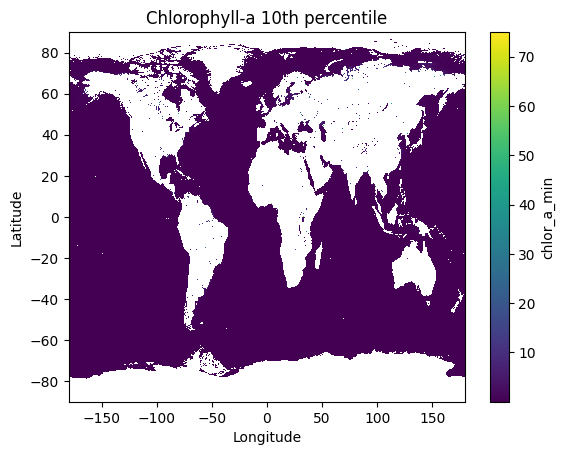

In [7]:
chlor_a_dataset['chlor_a_min'].plot()
plt.title('Chlorophyll-a 10th percentile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

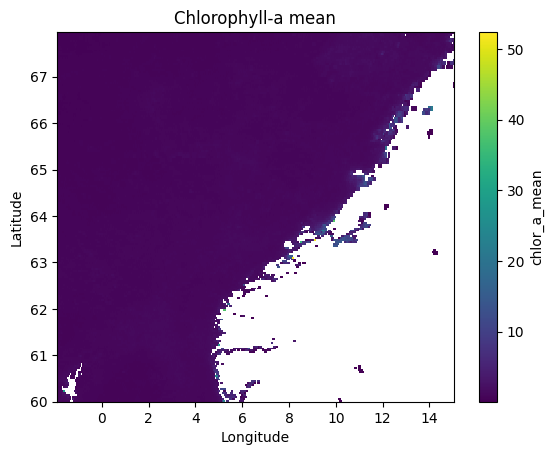

In [94]:
chlor_a_dataset['chlor_a_mean'].plot()
plt.title('Chlorophyll-a mean')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

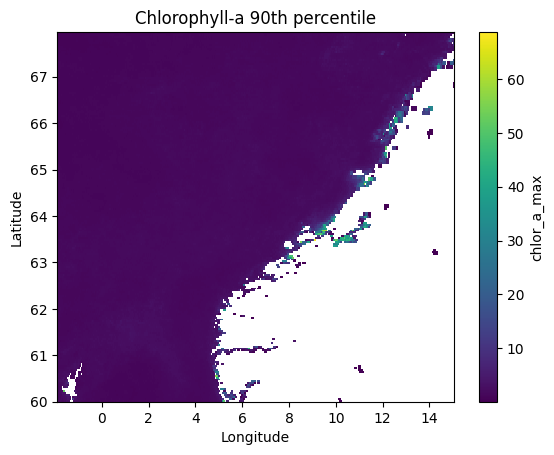

In [95]:
chlor_a_dataset['chlor_a_max'].plot()
plt.title('Chlorophyll-a 90th percentile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

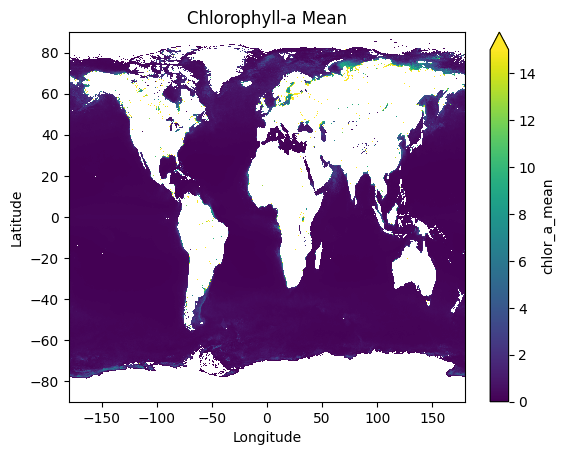

In [8]:
plot_obj = chlor_a_dataset['chlor_a_mean'].plot(
    cmap='viridis',  
    vmin=0,  #Set the minimum value for the color scale
    vmax=15  #Set the maximum value for the color scale
)
plt.title('Chlorophyll-a Mean')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Transform chlor data to EMOD grid

In [9]:
#1: Get null land points as verification
null_land_points = chlor_a_dataset['chlor_a_mean'].isnull().sum().values
ocean_points = chlor_a_dataset['chlor_a_mean'].notnull().sum().values

print(f"Null land points: {null_land_points}")
print(f"Ocean points: {ocean_points}")
print(f"Total points: {null_land_points + ocean_points}")

Null land points: 14502615
Ocean points: 22822185
Total points: 37324800


In [10]:
#Set the CRS for the chlor_a_dataset. 
#Latitude and longitude (WGS84) -> EPSG:4326
chlor_a_dataset['chlor_a_mean'] = chlor_a_dataset['chlor_a_mean'].rio.write_crs("EPSG:4326", inplace=True)
chlor_a_dataset['chlor_a_min'] = chlor_a_dataset['chlor_a_min'].rio.write_crs("EPSG:4326", inplace=True)
chlor_a_dataset['chlor_a_max'] = chlor_a_dataset['chlor_a_max'].rio.write_crs("EPSG:4326", inplace=True)

In [11]:
#4: Align the chlorophyll data with the bathymetry

tif_file = '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif'

tif_files = ['/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/aspect_cos.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/aspect_sin.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/bathymetry_32N_Clip_sample.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/broad_BPI_std.tif',
             '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/fine_BPI_std.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/log_ruggedness_1.tif', '/cluster/projects/itk-SINMOD/coral-mapping/data/raw_data/EMOD-tifs/slope.tif']


def align_satellite_and_bathymetry(chlorophyll_data, tif_file, resampling=Resampling.bilinear):
        
    with rioxarray.open_rasterio(tif_file) as tif:

        #Remove the band dimension from the tif data
        if 'band' in tif.dims:
            tif = tif.isel(band=0)

        chlorophyll_data_reprojected = chlorophyll_data.rio.reproject_match(tif, resampling=resampling)

        print(chlorophyll_data_reprojected.rio.bounds())
        print(chlorophyll_data_reprojected.dims)


        
        chlorophyll_data_mask = chlorophyll_data_reprojected['chlor_a_mean'].isnull()

        #Apply the mask to the EMOD data
        tif = tif.where(~chlorophyll_data_mask, np.nan)

        valid_mask = chlorophyll_data_reprojected['chlor_a_mean'].notnull()

        valid_columns = valid_mask.any(dim="y")  
        min_col = valid_columns.argmax().item()  #First non-NaN column from the left
        max_col = valid_columns.shape[0] - valid_columns[::-1].argmax().item() - 1  #First non-NaN column from the right

        #Find the first valid row (non-NaN) from the top (min row index)
        valid_rows = valid_mask.any(dim="x")  #Check for valid values in each row
        min_row = valid_rows.argmax().item()  #First non-NaN row from the top
        max_row = valid_rows.shape[0] - valid_rows[::-1].argmax().item() - 1  #Adjust for reverse indexing

        #Slice the raster to the bounding box of valid data
        clipped_chlorophyll_features = chlorophyll_data_reprojected.isel(x=slice(min_col, max_col + 1), y=slice(min_row, max_row + 1))
        
        clipped_tif = tif.rio.clip_box(minx=clipped_chlorophyll_features.rio.bounds()[0]+1, 
                                        miny=clipped_chlorophyll_features.rio.bounds()[1], 
                                        maxx=clipped_chlorophyll_features.rio.bounds()[2], 
                                        maxy=clipped_chlorophyll_features.rio.bounds()[3])
        
        clipped_tif = clipped_tif.reset_coords(drop=True)

    return clipped_chlorophyll_features, clipped_tif



In [12]:
chlor_a_features_reprojected, tif = align_satellite_and_bathymetry(chlor_a_dataset, tif_file)


(-148857.58868623473, 6580002.847672726, 866884.4113137652, 7621679.847672726)
FrozenMappingWarningOnValuesAccess({'x': 11162, 'y': 11447})


In [13]:
print(chlor_a_features_reprojected)

<xarray.Dataset> Size: 2GB
Dimensions:       (x: 11162, y: 11447)
Coordinates:
    spatial_ref   int64 8B 0
  * x             (x) float64 89kB -1.488e+05 -1.487e+05 ... 8.667e+05 8.668e+05
  * y             (y) float64 92kB 7.622e+06 7.622e+06 ... 6.58e+06 6.58e+06
Data variables:
    chlor_a_mean  (y, x) float32 511MB 0.5737 0.5736 0.5735 ... nan nan nan
    chlor_a_min   (y, x) float32 511MB 0.229 0.2285 0.228 0.2275 ... nan nan nan
    chlor_a_max   (y, x) float32 511MB 1.071 1.073 1.076 1.078 ... nan nan nan


In [14]:
emod = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/emod_features2/EMOD_features2.nc')

In [15]:
print(emod)

<xarray.Dataset> Size: 4GB
Dimensions:                     (x: 8325, y: 9671)
Coordinates:
  * x                           (x) float64 67kB -6.546e+04 ... 6.92e+05
  * y                           (y) float64 77kB 7.539e+06 ... 6.659e+06
Data variables:
    aspect_cos                  (y, x) float64 644MB ...
    aspect_sin                  (y, x) float64 644MB ...
    bathymetry_32N_Clip_sample  (y, x) float32 322MB ...
    broad_BPI_std               (y, x) float64 644MB ...
    fine_BPI_std                (y, x) float64 644MB ...
    log_ruggedness_1            (y, x) float32 322MB ...
    slope                       (y, x) float64 644MB ...


In [16]:
x_min, x_max = emod['x'].min().values, emod['x'].max().values
y_min, y_max = emod['y'].min().values, emod['y'].max().values

In [17]:
masked_chlor_a = chlor_a_features_reprojected.where(
    (chlor_a_features_reprojected['x'] >= x_min) & (chlor_a_features_reprojected['x'] <= x_max) &
    (chlor_a_features_reprojected['y'] >= y_min) & (chlor_a_features_reprojected['y'] <= y_max),
    drop=True
)

In [18]:
print(masked_chlor_a)

<xarray.Dataset> Size: 966MB
Dimensions:       (y: 9671, x: 8325)
Coordinates:
    spatial_ref   int64 8B 0
  * x             (x) float64 67kB -6.546e+04 -6.537e+04 ... 6.919e+05 6.92e+05
  * y             (y) float64 77kB 7.539e+06 7.539e+06 ... 6.659e+06 6.659e+06
Data variables:
    chlor_a_mean  (y, x) float32 322MB 0.4535 0.4531 0.4526 ... nan nan nan
    chlor_a_min   (y, x) float32 322MB 0.186 0.1857 0.1854 ... nan nan nan
    chlor_a_max   (y, x) float32 322MB 0.8085 0.8052 0.802 ... nan nan nan


In [19]:
masked_chlor_a.to_netcdf('/cluster/home/maikents/satellite_data/chlor_a_midnor_dataset_emod_grid2.nc')

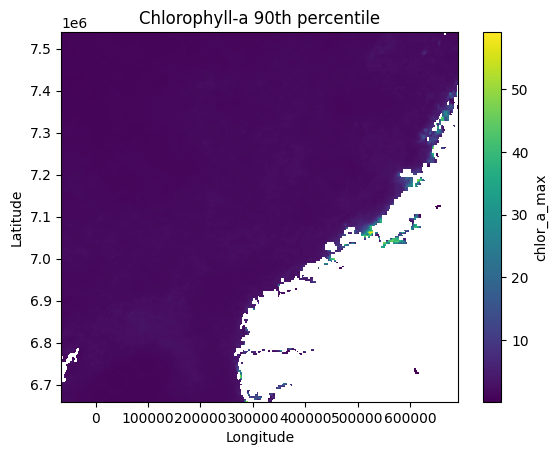

In [20]:
masked_chlor_a['chlor_a_max'].plot()
plt.title('Chlorophyll-a 90th percentile')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [2]:
masked_chlor_a = xr.open_dataset('/cluster/home/maikents/satellite_data/chlor_a_midnor_dataset_emod_grid.nc')

In [21]:
#Standardize the chlor a data

standardized_chlor_a = masked_chlor_a.copy()

chlor_a_mean_data = standardized_chlor_a['chlor_a_mean'].values
chlor_a_min_data = standardized_chlor_a['chlor_a_min'].values
chlor_a_max_data = standardized_chlor_a['chlor_a_max'].values

mean_flat = chlor_a_mean_data.flatten()
min_flat = chlor_a_min_data.flatten()
max_flat = chlor_a_max_data.flatten()

combined_data = np.stack([mean_flat, min_flat, max_flat], axis=1)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

scaled_mean = scaled_data[:, 0].reshape(chlor_a_mean_data.shape)
scaled_min = scaled_data[:, 1].reshape(chlor_a_min_data.shape)
scaled_max = scaled_data[:, 2].reshape(chlor_a_max_data.shape)

standardized_chlor_a['chlor_a_mean'] = (['y', 'x'], scaled_mean)
standardized_chlor_a['chlor_a_min'] = (['y', 'x'], scaled_min)
standardized_chlor_a['chlor_a_max'] = (['y', 'x'], scaled_max)

print(standardized_chlor_a)

<xarray.Dataset> Size: 966MB
Dimensions:       (y: 9671, x: 8325)
Coordinates:
    spatial_ref   int64 8B 0
  * x             (x) float64 67kB -6.546e+04 -6.537e+04 ... 6.919e+05 6.92e+05
  * y             (y) float64 77kB 7.539e+06 7.539e+06 ... 6.659e+06 6.659e+06
Data variables:
    chlor_a_mean  (y, x) float32 322MB -0.6705 -0.671 -0.6714 ... nan nan nan
    chlor_a_min   (y, x) float32 322MB -0.3415 -0.3424 -0.3433 ... nan nan nan
    chlor_a_max   (y, x) float32 322MB -0.4622 -0.4636 -0.4649 ... nan nan nan


In [22]:
standardized_chlor_a.to_netcdf('/cluster/home/maikents/features_midnor_2019/ready_for_training/chlor_a_midnor_dataset_emod_grid_standardized2.nc')

In [23]:
standardized_chlor_a = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/ready_for_training/chlor_a_midnor_dataset_emod_grid_standardized.nc')